In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=42748f2ca1aa101310bafc4e75c085cda67941ada44777ece3a7c351de2188f8
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
import os
import time
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy import linalg
# For FID and Inception score
from torchvision.models import inception_v3

# Import MedMNIST
import medmnist
from medmnist import INFO

# Define paths
dataroot = os.path.join(os.getcwd(), 'data')
# Create the 'data' directory if it doesn't exist
os.makedirs(dataroot, exist_ok=True)

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("generated_images", exist_ok=True)
os.makedirs("evaluation", exist_ok=True)

In [15]:
# Check for GPU availability and setup multi-GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    num_gpus = torch.cuda.device_count()
    print(f"Using {num_gpus} GPU(s)")
else:
    device = torch.device("cpu")
    num_gpus = 0
    print("Using CPU")

Using 2 GPU(s)


In [16]:
# Dataset / model hyperparameters
data_flag = 'pathmnist'  # MedMNIST variant
batch_size = 128 if num_gpus > 0 else 64  # Increase batch size for multi-GPU
image_size = 28
nc = 1                 # grayscale images
nz = 100               # latent vector size
ngf = 64               # generator feature map size
ndf = 64               # discriminator feature map size
num_epochs = 50
lr = 0.0002
beta1 = 0.5            # Adam optimizer parameter

In [17]:
# Get dataset info from medmnist
info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

In [6]:
# Define transforms: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure single channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = DataClass(root=dataroot, split='train', transform=transform, download=True)
val_dataset = DataClass(root=dataroot, split='val', transform=transform, download=True)
test_dataset = DataClass(root=dataroot, split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Dataset: {data_flag}, Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

100%|██████████| 206M/206M [00:16<00:00, 12.6MB/s] 


Using downloaded and verified file: /kaggle/working/data/pathmnist.npz
Using downloaded and verified file: /kaggle/working/data/pathmnist.npz
Dataset: pathmnist, Train: 89996, Val: 10004, Test: 7180


In [9]:
def visualize_dataset_samples(dataloader, title="Training Samples"):
    """Visualize a batch of images from the dataset"""
    batch = next(iter(dataloader))
    images = batch['image'] if isinstance(batch, dict) else batch[0]

    # Plot images
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Transpose the image to move the channels to the last dimension
            img = images[i].permute(1, 2, 0).squeeze().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.savefig(f"evaluation/{data_flag}_samples.png", bbox_inches='tight')
    plt.show()
    plt.close()

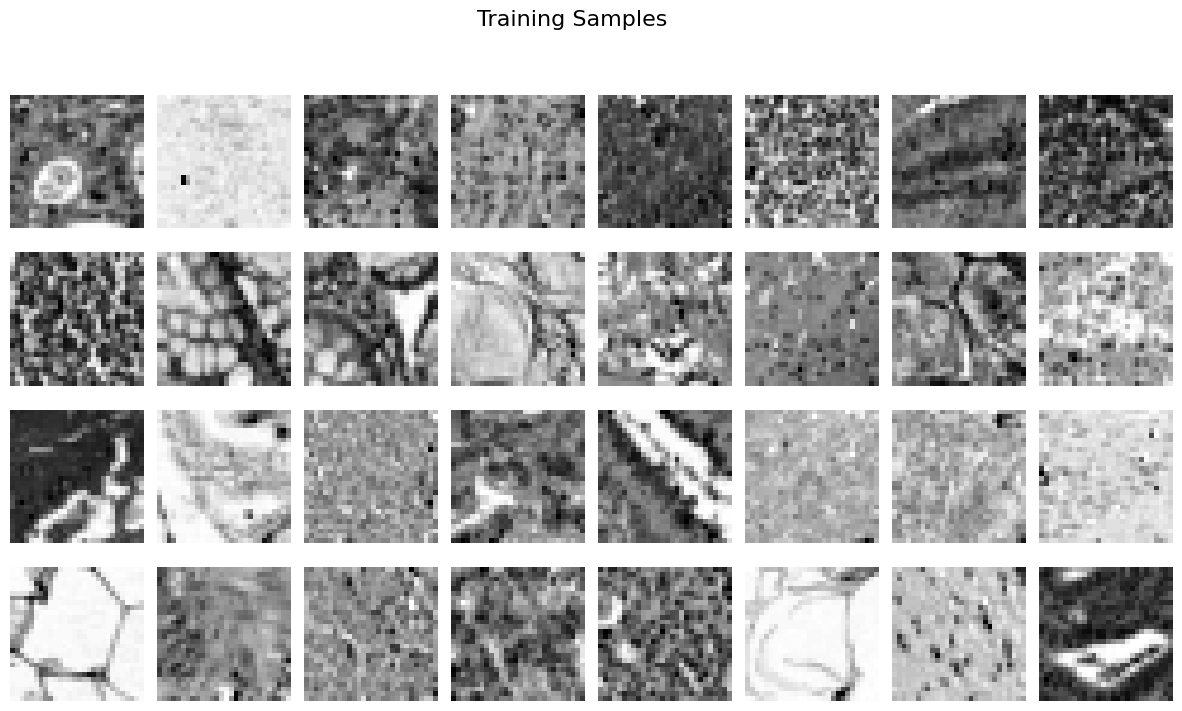

In [10]:
# Visualize training samples
visualize_dataset_samples(train_loader)


In [11]:
# Generator: A simple fully-connected then ConvTranspose network to produce 28x28 images.
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, ngf * 7 * 7),
            nn.BatchNorm1d(ngf * 7 * 7),
            nn.ReLU(True),
            # reshape to (ngf, 7, 7)
            nn.Unflatten(1, (ngf, 7, 7)),
            # Upsample to 14x14
            nn.ConvTranspose2d(ngf, ngf // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),
            # Upsample to 28x28
            nn.ConvTranspose2d(ngf // 2, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # output in range [-1,1]
        )
    def forward(self, input):
        return self.main(input)

In [12]:
# Discriminator (or Critic): Convolutional net that outputs a single number.
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),  # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),  # 14x14 -> 7x7
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(ndf * 2 * 7 * 7, 1)  # single output
        )
    def forward(self, input):
        return self.main(input)


In [22]:
# FID calculation functions
def get_inception_features(images, device, batch_size=32):
    # Load Inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    inception_model.fc = nn.Identity()  # Remove classifier layer
    
    # Process images
    if images.shape[1] == 1:  # Convert grayscale to RGB
        images = images.repeat(1, 3, 1, 1)
    
    # Resize to Inception input size
    if images.shape[2] != 299 or images.shape[3] != 299:
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    # Scale from [-1, 1] to [0, 1]
    images = (images + 1) / 2.0
    
    features = []
    n_batches = int(np.ceil(images.shape[0] / batch_size))
    
    with torch.no_grad():
        for i in range(n_batches):
            batch = images[i * batch_size:min((i + 1) * batch_size, len(images))].to(device)
            feat = inception_model(batch)
            features.append(feat.cpu().numpy())
    
    return np.concatenate(features, axis=0)

def calculate_fid(real_features, fake_features):
    # Calculate mean and covariance
    mu_real = np.mean(real_features, axis=0)
    mu_fake = np.mean(fake_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_fake = np.cov(fake_features, rowvar=False)
    
    # Calculate FID
    ssdiff = np.sum((mu_real - mu_fake) ** 2.0)
    covmean = linalg.sqrtm(sigma_real.dot(sigma_fake))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
    return fid

def calculate_inception_score(features, splits=10):
    probs = F.softmax(torch.from_numpy(features), dim=1).numpy()
    scores = []
    
    for i in range(splits):
        part = probs[i * (len(probs) // splits):(i + 1) * (len(probs) // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    
    return np.mean(scores), np.std(scores)

# Function for evaluating the model
def evaluate_gan(netG, test_loader, device, num_samples=1000, calc_fid=True):
    print("Evaluating GAN...")
    netG.eval()
    
    # Collect real samples
    real_images = []
    for batch in test_loader:
        images = batch['image'] if isinstance(batch, dict) else batch[0]
        real_images.append(images)
        if len(torch.cat(real_images)) >= num_samples:
            break
    
    real_images = torch.cat(real_images)[:num_samples]
    
    # Generate fake samples
    fake_images = []
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch_size_i = min(batch_size, num_samples - i)
            noise = torch.randn(batch_size_i, nz, device=device)
            fake = netG(noise).cpu()
            fake_images.append(fake)
    
    fake_images = torch.cat(fake_images)
    
    # Calculate metrics
    metrics = {}
    
    if calc_fid:
        print("Calculating FID score...")
        real_features = get_inception_features(real_images, device)
        fake_features = get_inception_features(fake_images, device)
        
        fid_score = calculate_fid(real_features, fake_features)
        metrics["fid_score"] = float(fid_score)
        print(f"FID Score: {fid_score:.4f}")
        
        # Calculate Inception Score
        print("Calculating Inception Score...")
        is_mean, is_std = calculate_inception_score(fake_features)
        metrics["inception_score_mean"] = float(is_mean)
        metrics["inception_score_std"] = float(is_std)
        print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")
    
    # Visualize generated samples
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        if i < 32:
            img = fake_images[i].permute(1, 2, 0).squeeze().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    
    plt.suptitle("Generated Samples", fontsize=16)
    plt.savefig(f"evaluation/{data_flag}_gen_samples.png", bbox_inches='tight')
    plt.show()
    plt.close()
    
    return metrics

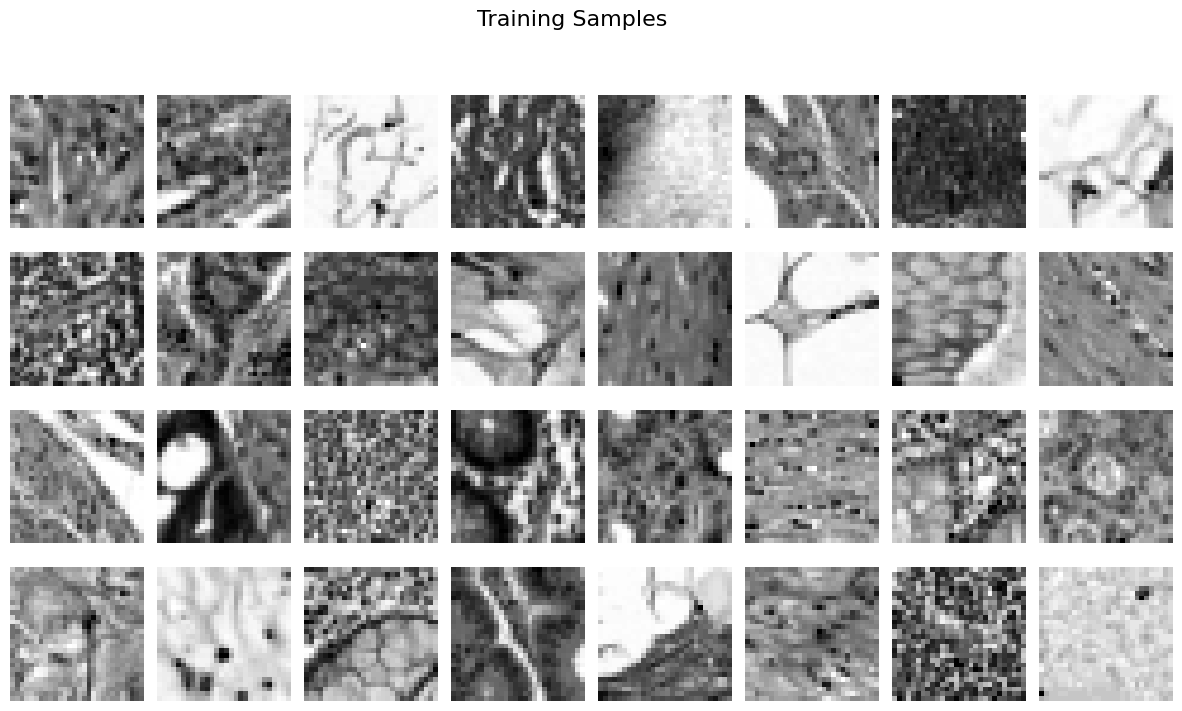

Starting LSGAN training...
Starting training...


Epoch 1/50:   0%|          | 0/1407 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)
Epoch 50/50: 100%|██████████| 1407/1407 [00:45<00:00, 31.06it/s, G_loss=0.439, D_loss=0.391]

Evaluating GAN...


Calculating FID score...


NameError: name 'inception_v3' is not defined

In [18]:
# Function to initialize model weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# Function to save generated samples
def save_samples(epoch, netG, fixed_noise, writer=None):
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    
    # Save images
    grid = vutils.make_grid(fake, padding=2, normalize=True)
    vutils.save_image(grid, f"generated_images/{data_flag}_epoch_{epoch}.png")
    
    # Add to TensorBoard if writer is provided
    if writer is not None:
        writer.add_image('Generated Images', grid, epoch)

# Main training function
def train_lsgan():
    print("Starting LSGAN training...")
    
    # Create log directory for TensorBoard
    os.makedirs("logs", exist_ok=True)
    writer = SummaryWriter(f"logs/{data_flag}_lsgan")
    
    # Initialize generator and discriminator
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    
    # Apply weight initialization
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    # Multi-GPU support
    if num_gpus > 1:
        netG = nn.DataParallel(netG)
        netD = nn.DataParallel(netD)
    
    # Optimizers
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Define the LS-GAN loss function (MSE)
    criterion = nn.MSELoss()
    
    # Fixed noise for visualization
    fixed_noise = torch.randn(64, nz, device=device)
    
    # Training loop
    print("Starting training...")
    
    # Monitoring variables
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    
    # For each epoch
    for epoch in range(num_epochs):
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            ############################
            # (1) Update D network
            ###########################
            # Train with real batch
            netD.zero_grad()
            
            # Format input batch
            real_cpu = batch['image'].to(device) if isinstance(batch, dict) else batch[0].to(device)
            b_size = real_cpu.size(0)
            
            # Ground truth labels: 1.0 for real
            label_real = torch.ones(b_size, 1, device=device)
            
            # Forward pass real batch through D
            output_real = netD(real_cpu)
            
            # Calculate loss on real images
            # LSGAN uses (D(x) - 1)^2 instead of -log(D(x))
            errD_real = criterion(output_real, label_real)
            
            # Backpropagation
            errD_real.backward()
            
            # Train with fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, device=device)
            
            # Generate fake image batch with G
            fake = netG(noise)
            
            # Ground truth labels: 0.0 for fake
            label_fake = torch.zeros(b_size, 1, device=device)
            
            # Classify fake batch with D
            output_fake = netD(fake.detach())
            
            # Calculate D's loss on the fake batch
            # LSGAN uses (D(G(z)))^2 instead of -log(1-D(G(z)))
            errD_fake = criterion(output_fake, label_fake)
            
            # Backpropagation
            errD_fake.backward()
            
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            
            # Update D
            optimizerD.step()
            
            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()
            
            # Since we just updated D, perform another forward pass of fake batch through D
            output = netD(fake)
            
            # Calculate G's loss based on this output
            # LSGAN uses (D(G(z)) - 1)^2 instead of -log(D(G(z)))
            errG = criterion(output, label_real)  # We want D to classify fake as real
            
            # Backpropagation
            errG.backward()
            
            # Update G
            optimizerG.step()
            
            # Save losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            # Output training stats
            if iters % 50 == 0:
                progress_bar.set_postfix({
                    'G_loss': errG.item(),
                    'D_loss': errD.item()
                })
                
                # Log to TensorBoard
                writer.add_scalar('Loss/Generator', errG.item(), iters)
                writer.add_scalar('Loss/Discriminator', errD.item(), iters)
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (iters == len(train_loader)-1)):
                save_samples(epoch, netG, fixed_noise, writer)
            
            iters += 1
        
        # Save model checkpoints after each epoch
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': netG.state_dict(),
                'discriminator_state_dict': netD.state_dict(),
                'optimizer_g_state_dict': optimizerG.state_dict(),
                'optimizer_d_state_dict': optimizerD.state_dict(),
                'g_loss': errG.item(),
                'd_loss': errD.item(),
            }, f"checkpoints/{data_flag}_lsgan_epoch_{epoch+1}.pt")
    
    
# Run the training
if __name__ == "__main__":
    # Visualize dataset samples first
    visualize_dataset_samples(train_loader)
    
    # Train the LSGAN
    netG, netD = train_lsgan()

# Ignore the error above it has been resolved below

Evaluating GAN...


<ipython-input-25-1443eff87ded>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Calculating FID score...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 189MB/s] 


FID Score: 44.6029
Calculating Inception Score...
Inception Score: 1.0788 ± 0.0058


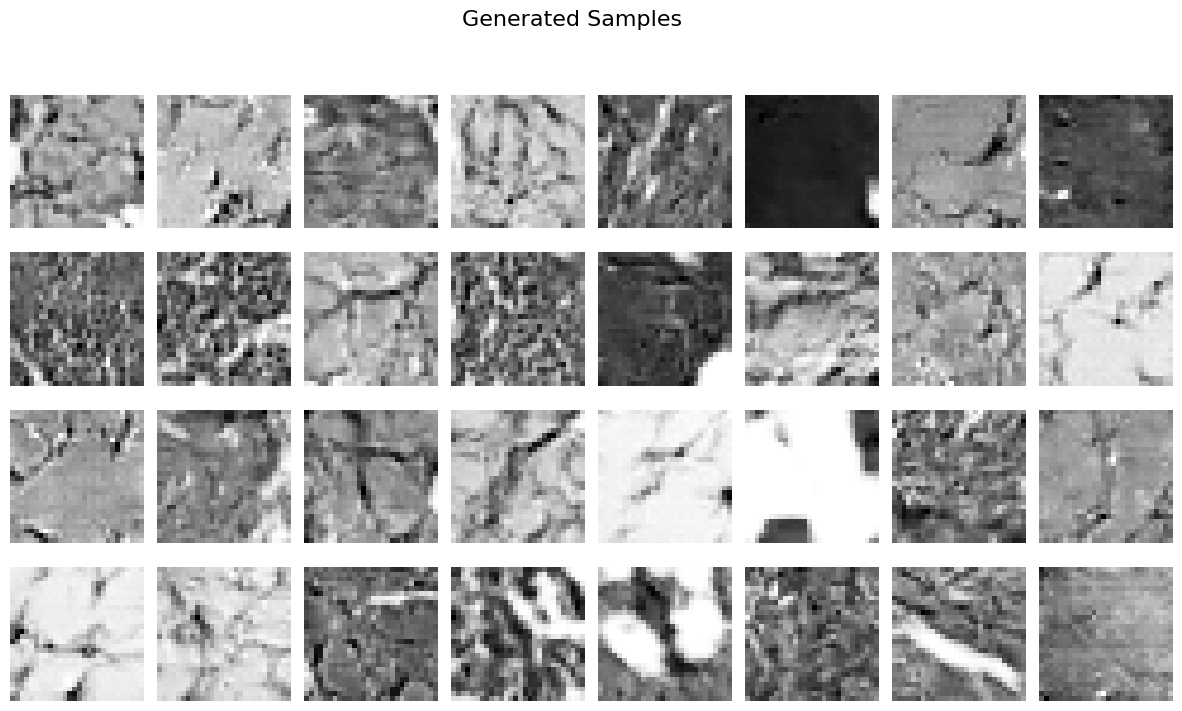

FID Score: 44.6029
Inception Score: 1.0788 ± 0.0058


In [25]:
# Required imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import inception_v3
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

# Initialize your model architecture (make sure this matches your training architecture)
# You'll need to define your Generator class here, or import it from your module
# For example:
netG = Generator().to(device)

# If you used DataParallel during training
if num_gpus > 1:
    netG = nn.DataParallel(netG)

# Load your saved model
checkpoint_path = f"checkpoints/{data_flag}_lsgan_epoch_50.pt"  # Adjust path as needed
checkpoint = torch.load(checkpoint_path)
netG.load_state_dict(checkpoint['generator_state_dict'])

# Set model to evaluation mode
netG.eval()

# Run evaluation
metrics = evaluate_gan(netG, test_loader, device)

# Print and save metrics
print(f"FID Score: {metrics['fid_score']:.4f}")
print(f"Inception Score: {metrics['inception_score_mean']:.4f} ± {metrics['inception_score_std']:.4f}")

# Save metrics to file
import json
with open(f"evaluation/{data_flag}_lsgan_metrics.json", "w") as f:
    json.dump(metrics, f)

In [26]:
!ls -lah /kaggle/working/


total 36K
drwxr-xr-x 9 root root 4.0K Mar 29 07:03 .
drwxr-xr-x 5 root root 4.0K Mar 29 06:50 ..
drwxr-xr-x 2 root root 4.0K Mar 29 07:42 checkpoints
drwxr-xr-x 2 root root 4.0K Mar 29 06:52 data
drwxr-xr-x 2 root root 4.0K Mar 29 07:55 evaluation
drwxr-xr-x 2 root root 4.0K Mar 29 07:41 generated_images
drwxr-xr-x 2 root root 4.0K Mar 29 06:54 .ipynb_checkpoints
drwxr-xr-x 3 root root 4.0K Mar 29 07:03 logs
drwxr-xr-x 2 root root 4.0K Mar 29 06:50 .virtual_documents


In [43]:
# Navigate to the working directory
!cd /kaggle/working/
!ls



checkpoints  data  data.zip  evaluation  generated_images  logs


In [44]:
!zip -r generated_images.zip /kaggle/working/


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/evaluation/ (stored 0%)
  adding: kaggle/working/evaluation/pathmnist_samples.png (deflated 12%)
  adding: kaggle/working/evaluation/pathmnist_gen_samples.png (deflated 13%)
  adding: kaggle/working/evaluation/pathmnist_lsgan_metrics.json (deflated 25%)
  adding: kaggle/working/.ipynb_checkpoints/ (stored 0%)
  adding: kaggle/working/generated_images/ (stored 0%)
  adding: kaggle/working/generated_images/pathmnist_epoch_8.png (deflated 3%)
  adding: kaggle/working/generated_images/pathmnist_epoch_31.png (deflated 2%)
  adding: kaggle/working/generated_images/pathmnist_epoch_7.png (deflated 3%)
  adding: kaggle/working/generated_images/pathmnist_epoch_39.png (deflated 2%)
  adding: kaggle/working/generated_images/pathmnist_epoch_44.png (deflated 2%)
  adding: kaggle/working/generated_images/pathmnist_epoch_15.png (deflated 3%)
  adding: kaggle/working/generated_images/pathmnist_epoch_27.png (deflated 3%)
  adding: kaggle/wor

In [45]:
!zip -r evaluation.zip /kaggle/working/


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/evaluation/ (stored 0%)
  adding: kaggle/working/evaluation/pathmnist_samples.png (deflated 12%)
  adding: kaggle/working/evaluation/pathmnist_gen_samples.png (deflated 13%)
  adding: kaggle/working/evaluation/pathmnist_lsgan_metrics.json (deflated 25%)
  adding: kaggle/working/.ipynb_checkpoints/ (stored 0%)
  adding: kaggle/working/generated_images/ (stored 0%)
  adding: kaggle/working/generated_images/pathmnist_epoch_8.png (deflated 3%)
  adding: kaggle/working/generated_images/pathmnist_epoch_31.png (deflated 2%)
  adding: kaggle/working/generated_images/pathmnist_epoch_7.png (deflated 3%)
  adding: kaggle/working/generated_images/pathmnist_epoch_39.png (deflated 2%)
  adding: kaggle/working/generated_images/pathmnist_epoch_44.png (deflated 2%)
  adding: kaggle/working/generated_images/pathmnist_epoch_15.png (deflated 3%)
  adding: kaggle/working/generated_images/pathmnist_epoch_27.png (deflated 3%)
  adding: kaggle/wor

In [46]:
!zip -r checkpoints.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/evaluation/ (stored 0%)
  adding: kaggle/working/evaluation/pathmnist_samples.png (deflated 12%)
  adding: kaggle/working/evaluation/pathmnist_gen_samples.png (deflated 13%)
  adding: kaggle/working/evaluation/pathmnist_lsgan_metrics.json (deflated 25%)
  adding: kaggle/working/.ipynb_checkpoints/ (stored 0%)
  adding: kaggle/working/generated_images/ (stored 0%)
  adding: kaggle/working/generated_images/pathmnist_epoch_8.png (deflated 3%)
  adding: kaggle/working/generated_images/pathmnist_epoch_31.png (deflated 2%)
  adding: kaggle/working/generated_images/pathmnist_epoch_7.png (deflated 3%)
  adding: kaggle/working/generated_images/pathmnist_epoch_39.png (deflated 2%)
  adding: kaggle/working/generated_images/pathmnist_epoch_44.png (deflated 2%)
  adding: kaggle/working/generated_images/pathmnist_epoch_15.png (deflated 3%)
  adding: kaggle/working/generated_images/pathmnist_epoch_27.png (deflated 3%)
  adding: kaggle/wor